# Auto Enconder For Noise Image

Nama : Aaron Winston gho
NIM : 2702210522 ( GENAP )
Sebagai data scientist anda mendapat tantangan untuk menyelesaikan masalah
data image yang memiliki noise. Anda perlu membangun model deep learning yang mampu membersihkan data
image yang mengandung noise menjadi data yang bersih tanpa noise. Namun sayangnya anda tidak memiliki data
yang mengandung noise dengan cukup, sehingga anda perlu membuat image data dengan memberikan noise nilai
acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1. Data
image yang anda gunakan adalah data pada link berikut:
https://drive.google.com/drive/folders/1-Tdpj25TUPpn_FBfNVcEoTtjQstTKOZl?usp=sharing , dimana jika anda
memiliki NIM genap, anda akan menggunakan data A_23, dan bila anda memiliki NIM ganjil akan
menggunakan data B_23.

Menggunakan Data A_23

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


# Import Library

In [2]:
# Library
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import hashlib
from PIL import Image
from tqdm import tqdm
import zipfile
from collections import Counter
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Input,Conv2D,MaxPooling2D,UpSampling2D,Dropout)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
zip_path = '/content/drive/MyDrive/ujian DL/A_23.zip'
extract_dir = '/content/A_23'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
main_folder = os.path.join(extract_dir, 'A_23')
all_files = [f for f in os.listdir(main_folder) if f.lower().endswith('.jpg')]
print('Jumlah gambar:', len(all_files))

Jumlah gambar: 1074


In [5]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Alasannya:

Dengan mengetahui jumlah gambar, kita bisa memastikan dataset sudah lengkap dan tidak ada file yang hilang atau corrupt.
Informasi ini penting agar kita bisa memperkirakan apakah jumlah data cukup untuk melatih model deep learning, serta mengantisipasi jika ternyata perlu melakukan augmentasi data.

# A. EDA

## Visualisasi Gambar ( Secara Acak )

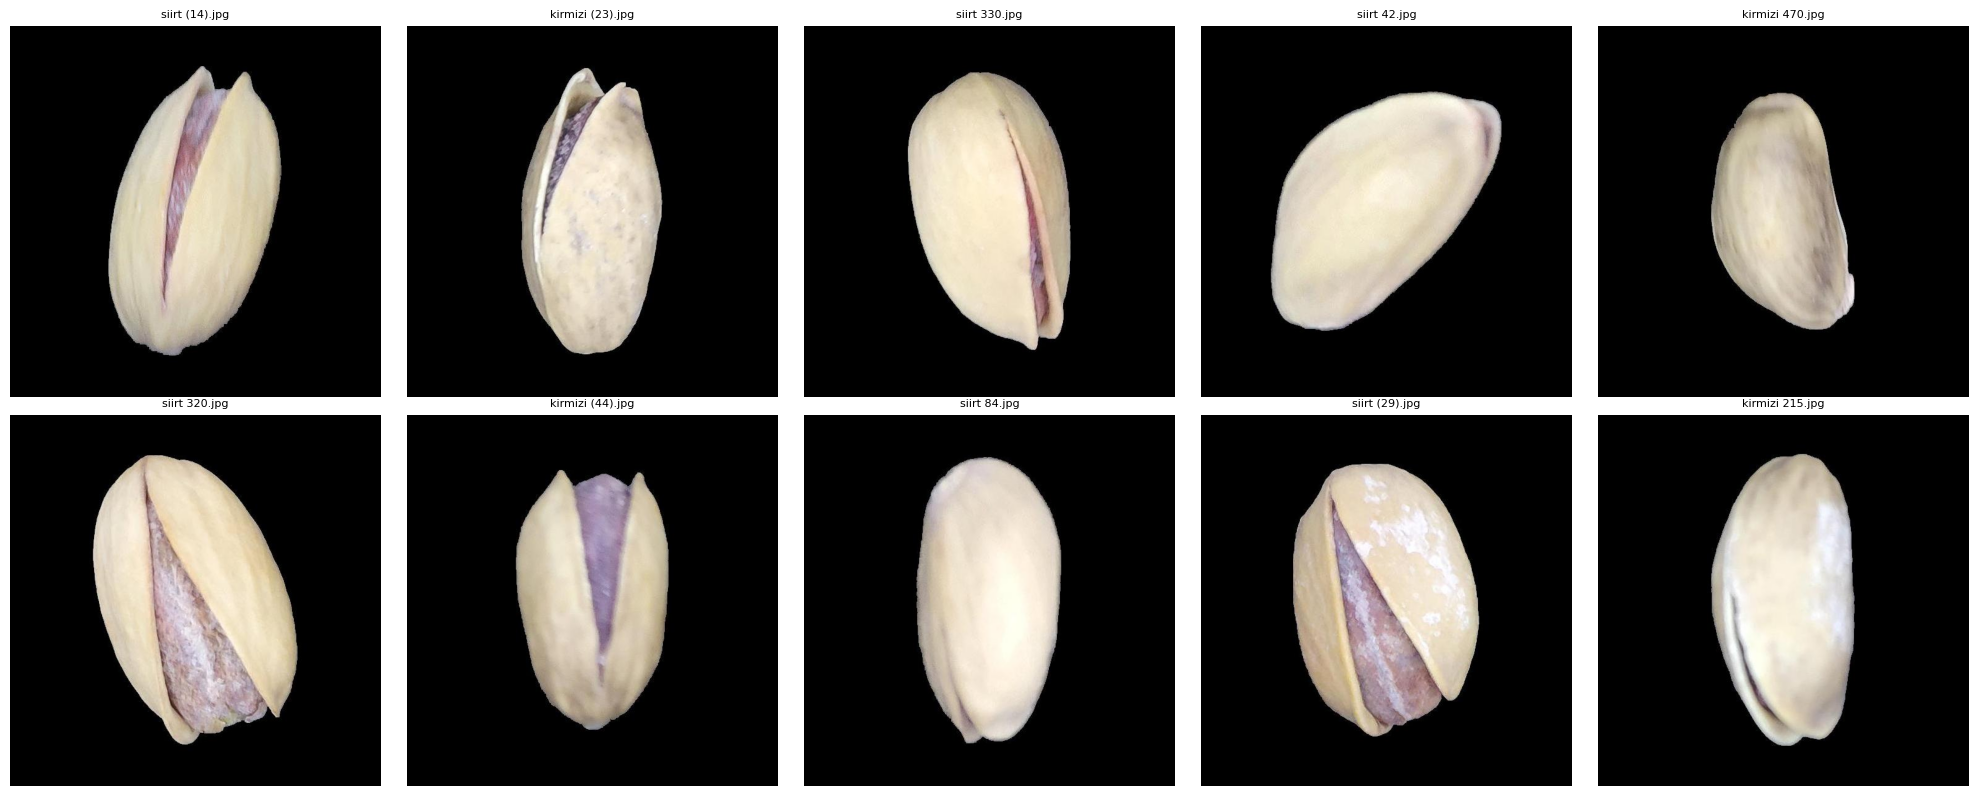

In [6]:
plt.figure(figsize=(20,8))
sample_files = random.sample(all_files, 10)
for i, fname in enumerate(sample_files):
    img_path = os.path.join(main_folder, fname)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(fname, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

Alasan:

Dengan visualisasi ini, kita bisa memastikan gambar yang ada memang sesuai dengan masalah yang akan diselesaikan (tidak blur, tidak rusak, dan objeknya jelas).
Visualisasi juga membantu kita memahami variasi objek, pencahayaan, warna, dan kondisi gambar secara umum, sehingga bisa menyiapkan strategi preprocessing dan modeling yang sesuai.
Melihat gambar secara langsung juga penting agar kita bisa menilai tingkat kesulitan tugas denoising pada dataset tersebut.

Insight:
Objek utama pada gambar kita ternyata adalah kacang pistachio dan sangat jelas dan mudah dikenali. selain itu kita juga bisa tau beberapa hal :
1. Warna dan tekstur gambar relatif seragam - kita akan cek nanti untuk channelnya
2. Latar belakang gambar umumnya sederhana dan tidak ramai.
Pencahayaan pada gambar rata-rata baik, tanpa area yang terlalu gelap atau terlalu terang. ( Notes background hitam )
3. Tidak ditemukan gambar yang blur atau rusak secara visual tapi ada orientasi atau penempatan rotasi yg berbedqa beda pada pistachio

## Cek Ukuran dan Chanel Gambar

Jumlah kombinasi unik ukuran & channel: 1
Ukuran: (600, 600), Channel: RGB, Jumlah: 1074


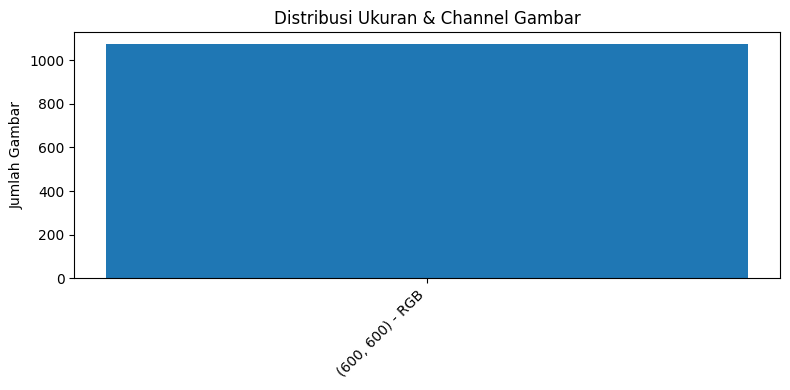

In [7]:
size_list = []
mode_list = []
for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    with Image.open(img_path) as img:
        size_list.append(img.size)
        mode_list.append(img.mode)

counter = Counter(zip(size_list, mode_list))
print("Jumlah kombinasi unik ukuran & channel:", len(counter))
for k, v in counter.items():
    print(f"Ukuran: {k[0]}, Channel: {k[1]}, Jumlah: {v}")

labels = [f"{size} - {mode}" for size, mode in counter.keys()]
plt.figure(figsize=(8,4))
plt.bar(labels, counter.values())
plt.xticks(rotation=45, ha='right')
plt.title("Distribusi Ukuran & Channel Gambar")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

yes dr sini kita lihat kalau secara size dataset kita sudah aman dan bersih dan juga secara warna semuanya satu chanel di RGB.

## Distribusi nilai piksel

In [ ]:
pixel_means = []
pixel_stds = []
pixel_mins = []
pixel_maxs = []

for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    img = Image.open(img_path).convert('RGB')
    arr = np.asarray(img) / 255.0  
    pixel_means.append(arr.mean())
    pixel_stds.append(arr.std())
    pixel_mins.append(arr.min())
    pixel_maxs.append(arr.max())

print("Rata-rata mean pixel semua gambar:", np.mean(pixel_means))
print("Rata-rata std pixel semua gambar:", np.mean(pixel_stds))
print("Min pixel global:", np.min(pixel_mins))
print("Max pixel global:", np.max(pixel_maxs))

Rata-rata mean pixel semua gambar: 0.18746620614132958
Rata-rata std pixel semua gambar: 0.3392861055316262
Min pixel global: 0.0
Max pixel global: 1.0


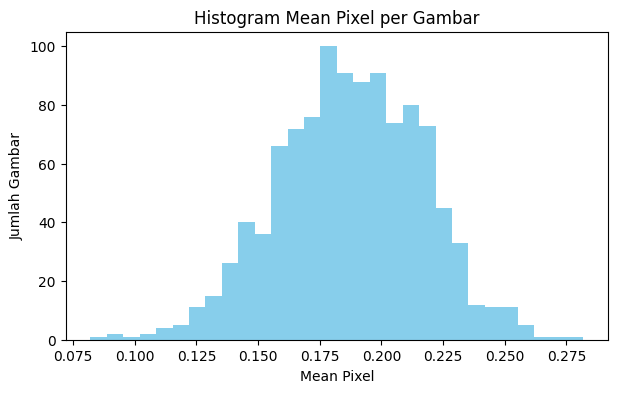

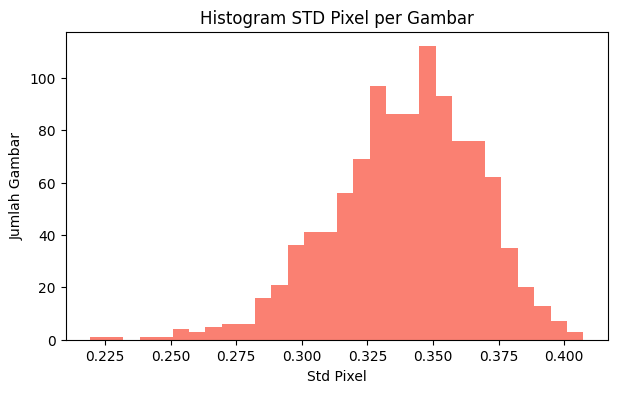

In [9]:
plt.figure(figsize=(7,4))
plt.hist(pixel_means, bins=30, color='skyblue')
plt.title("Histogram Mean Pixel per Gambar")
plt.xlabel("Mean Pixel")
plt.ylabel("Jumlah Gambar")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(pixel_stds, bins=30, color='salmon')
plt.title("Histogram STD Pixel per Gambar")
plt.xlabel("Std Pixel")
plt.ylabel("Jumlah Gambar")
plt.show()

Berdasarkan statistik ini, kita dapat menyimpulkan bahwa gambar-gambar pada dataset memiliki dominasi warna gelap dengan variasi warna yang cukup beragam. Hal ini menjadi perhatian penting saat kita melakukan penambahan noise dan training model denoising, karena model harus mampu belajar mengenali detail pada gambar yang cenderung gelap dan beragam.

## Duplicates

In [10]:
hashes = set()
dupes = []
for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    with open(img_path, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()
        if filehash in hashes:
            dupes.append(fname)
        else:
            hashes.add(filehash)

print("Jumlah gambar duplikat ditemukan:", len(dupes))
if dupes:
    print("Contoh file duplikat:", dupes[:5])
else:
    print("Tidak ditemukan duplikat.")

Jumlah gambar duplikat ditemukan: 0
Tidak ditemukan duplikat.


ga ada duplikat jadi aman , kita lanjut ke eda berikutnya ini dilakukan supaya kalau ada dups harus di drop karena nantinya jadi bias model kita

## Cek tipe data

In [11]:
all_files_raw = os.listdir(main_folder)
non_jpg = [f for f in all_files_raw if not f.lower().endswith('.jpg')]
print("Jumlah file non-JPG:", len(non_jpg))
if non_jpg:
    print("Contoh file non-JPG:", non_jpg[:5])
else:
    print("Semua file adalah JPG.")


Jumlah file non-JPG: 0
Semua file adalah JPG.



Mayoritas gambar pada dataset memiliki tingkat kecerahan rata-rata yang hampir sama, yaitu cenderung gelap.
Distribusi mean pixel membentuk kurva lonceng yang normal, tanpa ada gambar yang sangat terang atau sangat gelap secara ekstrem.
Artinya, data ini cukup konsisten dan seragam dari segi kecerahan, sehingga model tidak perlu menangani kasus gambar yang terlalu terang atau terlalu gelap.

# B. Preprocessing

## Listing Folder Untuk X & Y Image

In [ ]:
main_folder = os.path.join(extract_dir, 'A_23')  
all_files = [f for f in os.listdir(main_folder) if f.lower().endswith('.jpg')]

clean_dir = '/content/clean_image'
noise_dir = '/content/noise_image'

os.makedirs(clean_dir, exist_ok=True)
os.makedirs(noise_dir, exist_ok=True)

## Resize ke 100x100 terus masukin ke folder

In [13]:
img_size = (100, 100)
for fname in all_files:
    src = os.path.join(main_folder, fname)
    img = Image.open(src).convert('RGB')
    img_resized = img.resize(img_size)
    img_resized.save(os.path.join(clean_dir, fname))
    img_resized.save(os.path.join(noise_dir, fname))

print(f"Total file di 'clean_image': {len(os.listdir(clean_dir))}")
print(f"Total file di 'noise_image': {len(os.listdir(noise_dir))}")

Total file di 'clean_image': 1074
Total file di 'noise_image': 1074


## Add Noise With Gaussian

In [14]:
noise_files = [f for f in os.listdir(noise_dir) if f.lower().endswith('.jpg')]

for fname in noise_files:
    img_path = os.path.join(noise_dir, fname)
    img = Image.open(img_path).convert('RGB')
    arr = np.asarray(img) / 255.0
    noise = np.random.normal(loc=0.0, scale=0.1, size=arr.shape)
    noisy_img = np.clip(arr + noise, 0, 1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    Image.fromarray(noisy_img).save(img_path)


## Split Data

In [17]:
filelist = [f for f in os.listdir(clean_dir) if f.lower().endswith('.jpg')]
filelist.sort()
n_total = len(filelist)
train_idx, temp_idx = train_test_split(np.arange(n_total), test_size=0.2, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, random_state=42)

def subset(lst, idx):
    return [lst[i] for i in idx]

train_files = subset(filelist, train_idx)
val_files   = subset(filelist, val_idx)
test_files  = subset(filelist, test_idx)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 859, Val: 107, Test: 108


## Load pasangan Noise dan Clean

In [20]:
def get_image_pairs(noise_dir, clean_dir, namelist):
    X, Y = [], []
    for name in namelist:
        noisy_img = cv2.cvtColor(cv2.imread(os.path.join(noise_dir, name)), cv2.COLOR_BGR2RGB)
        clean_img = cv2.cvtColor(cv2.imread(os.path.join(clean_dir, name)), cv2.COLOR_BGR2RGB)
        X.append(noisy_img.astype(np.float32)/255.0)
        Y.append(clean_img.astype(np.float32)/255.0)
    return np.stack(X), np.stack(Y)

X_train, Y_train = get_image_pairs(noise_dir, clean_dir, train_files)
X_val, Y_val = get_image_pairs(noise_dir, clean_dir, val_files)
X_test, Y_test = get_image_pairs(noise_dir, clean_dir, test_files)

## Check apakah sudah aman ?

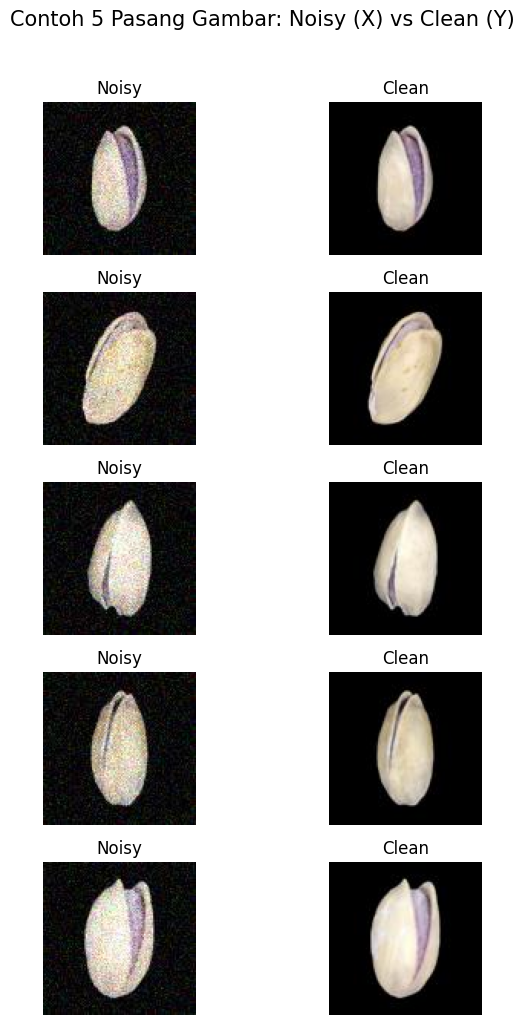

In [22]:
n_examples = 5

plt.figure(figsize=(7, 2 * n_examples))
for i in range(n_examples):
    plt.subplot(n_examples, 2, 2*i + 1)
    plt.imshow(X_train[i])
    plt.title("Noisy")
    plt.axis('off')
    plt.subplot(n_examples, 2, 2*i + 2)
    plt.imshow(Y_train[i])
    plt.title("Clean")
    plt.axis('off')

plt.suptitle("Contoh 5 Pasang Gambar: Noisy (X) vs Clean (Y)", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# C. Training Model

In [36]:
input_layer = Input(shape=(100, 100, 3), name='input_layer')

x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d')(input_layer)
x = MaxPooling2D((2, 2), padding='same', name='max_pooling2d')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
x = MaxPooling2D((2, 2), padding='same', name='max_pooling2d_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_2')(x)

x = UpSampling2D((2, 2), name='up_sampling2d')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_3')(x)
x = UpSampling2D((2, 2), name='up_sampling2d_1')(x)
output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='conv2d_4')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = autoencoder.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, Y_val)
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.1383 - val_loss: 0.0124
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0129 - val_loss: 0.0099
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.

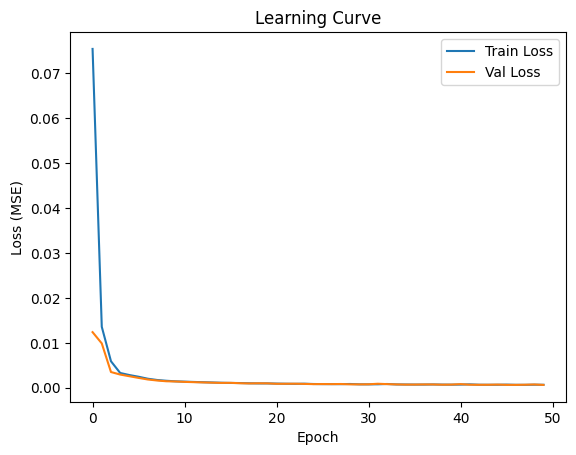

In [38]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Learning Curve')
plt.show()

#E. Evaluatiion with 4 Metrics

In [28]:
Y_pred = autoencoder.predict(X_test)

def batch_metrics(y_true, y_pred):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []
    mae_scores = []
    for i in range(len(y_true)):
        true_img = (y_true[i] * 255).astype(np.uint8)
        pred_img = (y_pred[i] * 255).astype(np.uint8)
        ssim_score = ssim(true_img, pred_img, data_range=255, channel_axis=2)
        psnr_score = psnr(true_img, pred_img, data_range=255)
        mse_score = np.mean((y_true[i] - y_pred[i]) ** 2)
        mae_score = np.mean(np.abs(y_true[i] - y_pred[i]))
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mse_scores.append(mse_score)
        mae_scores.append(mae_score)
    return {
        'ssim': np.mean(ssim_scores),
        'psnr': np.mean(psnr_scores),
        'mse' : np.mean(mse_scores),
        'mae' : np.mean(mae_scores)
    }

metrics = batch_metrics(Y_test, Y_pred)
print(f"Rata-rata SSIM pada data test: {metrics['ssim']:.4f}")
print(f"Rata-rata PSNR pada data test: {metrics['psnr']:.2f} dB")
print(f"Rata-rata MSE  pada data test: {metrics['mse']:.6f}")
print(f"Rata-rata MAE  pada data test: {metrics['mae']:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Rata-rata SSIM pada data test: 0.9293
Rata-rata PSNR pada data test: 31.16 dB
Rata-rata MSE  pada data test: 0.000806
Rata-rata MAE  pada data test: 0.010759


Evaluasi dan Insight Model Autoencoder Baseline:

Nilai rata-rata SSIM pada data test adalah 0.9293, yang menunjukkan model autoencoder mampu menghasilkan gambar hasil denoising yang sangat mirip secara struktur visual dengan gambar aslinya.
Semakin mendekati 1, kualitas struktur dan detail pada gambar semakin baik.
Rata-rata PSNR sebesar 31.16 dB menandakan noise residual yang masih tersisa pada hasil output model sudah sangat kecil, karena umumnya PSNR di atas 30 dB sudah dianggap sangat baik untuk tugas image denoising.
Nilai MSE rata-rata sebesar 0.000806 dan MAE 0.010759 juga tergolong sangat rendah, yang artinya perbedaan pixel antara gambar hasil model dan gambar ground truth hanya sedikit.

# D. Modifikasi + Pilih Yang terbaik untuk di hypertuning

## Modifikasi Arsitektur Autoencoder dan Alasannya

1. **Menambah Jumlah dan Kedalaman Layer Conv2D**
   - **Perubahan:** Layer Conv2D dibuat lebih banyak dan lebih dalam dibanding model baseline.
   - **Alasan:**  
     Model yang lebih dalam dengan lebih banyak filter mampu mengekstraksi fitur gambar yang lebih kompleks, sehingga hasil denoising menjadi lebih detail dan tajam.

2. **Menambahkan BatchNormalization setelah setiap Conv2D**
   - **Perubahan:** Setelah setiap Conv2D, ditambahkan BatchNormalization sebelum aktivasi.
   - **Alasan:**  
     BatchNormalization membantu menstabilkan dan mempercepat proses training, serta mengurangi risiko overfitting dan vanishing/exploding gradient.

3. **Menambah Dropout setelah beberapa pooling**
   - **Perubahan:** Dropout kecil (0.1) ditambahkan setelah pooling di bagian encoder dan decoder.
   - **Alasan:**  
     Dropout berfungsi sebagai regularisasi untuk mencegah model overfitting dan terlalu "hafal" noise pada data training.

**Kesimpulan:**  
Dengan seluruh modifikasi di atas, model menjadi lebih dalam, lebih stabil saat training, dan lebih mampu mengenali serta mengembalikan detail pada gambar yang terkena noise. Diharapkan hasil evaluasi pada metrik SSIM, PSNR, MSE, dan MAE menjadi lebih baik dibandingkan model baseline.


In [ ]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)    
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)   
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  

# Decoder
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)   
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)   
output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_mod = Model(inputs=input_layer, outputs=output_layer)
autoencoder_mod.compile(optimizer='adam', loss='mse')
autoencoder_mod.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,211 (477.39 KB)

 Trainable params: 122,019 (476.64 KB)

 Non-trainable params: 192 (768.00 B)

In [40]:
history_mod = autoencoder_mod.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, Y_val)
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - loss: 0.1219 - val_loss: 0.0671
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0030 - val_loss: 0.0211
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020 - val_loss: 0.0299
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017 - val_loss: 0.0399
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 0.0443
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013 - val_loss: 0.0447
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012 - val_loss: 0.0435
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 0.0402
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0010 - val_loss: 0.0355
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.7710e-04 - val_loss: 0.0304
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.3858e-04 - val_loss: 0.0251
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step 

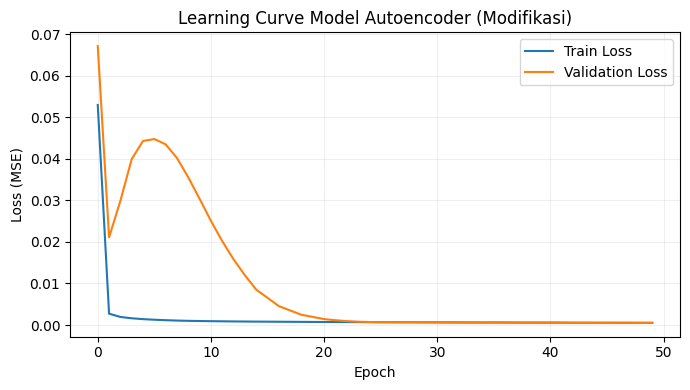

In [41]:
plt.figure(figsize=(7,4))
plt.plot(history_mod.history['loss'], label='Train Loss')
plt.plot(history_mod.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curve Model Autoencoder (Modifikasi)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [42]:
Y_pred_mod = autoencoder_mod.predict(X_test)

def batch_metrics(y_true, y_pred):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []
    mae_scores = []
    for i in range(len(y_true)):
        true_img = (y_true[i] * 255).astype(np.uint8)
        pred_img = (y_pred[i] * 255).astype(np.uint8)
        ssim_score = ssim(true_img, pred_img, data_range=255, channel_axis=2)
        psnr_score = psnr(true_img, pred_img, data_range=255)
        mse_score = np.mean((y_true[i] - y_pred[i]) ** 2)
        mae_score = np.mean(np.abs(y_true[i] - y_pred[i]))
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mse_scores.append(mse_score)
        mae_scores.append(mae_score)
    return {
        'ssim': np.mean(ssim_scores),
        'psnr': np.mean(psnr_scores),
        'mse' : np.mean(mse_scores),
        'mae' : np.mean(mae_scores)
    }

metrics_mod = batch_metrics(Y_test, Y_pred_mod)
print(f"Rata-rata SSIM pada data test: {metrics_mod['ssim']:.4f}")
print(f"Rata-rata PSNR pada data test: {metrics_mod['psnr']:.2f} dB")
print(f"Rata-rata MSE  pada data test: {metrics_mod['mse']:.6f}")
print(f"Rata-rata MAE  pada data test: {metrics_mod['mae']:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Rata-rata SSIM pada data test: 0.9398
Rata-rata PSNR pada data test: 33.11 dB
Rata-rata MSE  pada data test: 0.000518
Rata-rata MAE  pada data test: 0.009255


Evaluasi Model Autoencoder Modifikasi

Rata-rata SSIM pada data test meningkat menjadi 0.9398 (dari baseline 0.9293), artinya struktur dan detail visual hasil denoising lebih mendekati gambar aslinya.
PSNR juga meningkat menjadi 33.11 dB (dari 31.16 dB pada baseline), yang menunjukkan kualitas gambar hasil model jauh lebih baik dan noise residual semakin kecil.
Nilai MSE menurun ke 0.000518 (baseline: 0.000806) dan MAE turun ke 0.009255 (baseline: 0.010759), menandakan rata-rata error tiap pixel semakin kecil.
Secara keseluruhan, setiap metrik utama mengalami peningkatan signifikan dibanding model baseline.

## Hyperparameter tuning modifikasi model karena lebih unggul

In [45]:
learning_rates = [0.001, 0.0005]
batch_sizes = [16, 32]

results = []

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with lr={lr}, batch_size={bs} + EarlyStopping")
        # Build model
        input_layer = Input(shape=(100, 100, 3))
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

        # Train with EarlyStopping
        history = model.fit(
            X_train, Y_train,
            epochs=100,
            batch_size=bs,
            shuffle=True,
            validation_data=(X_val, Y_val),
            callbacks=[earlystop],
            verbose=0
        )
        # Eval di test set
        Y_pred = model.predict(X_test)
        metrics = batch_metrics(Y_test, Y_pred)
        result = {
            'lr': lr,
            'batch_size': bs,
            'ssim': metrics['ssim'],
            'psnr': metrics['psnr'],
            'mse': metrics['mse'],
            'mae': metrics['mae']
        }
        results.append(result)
        print(f"Done: SSIM={metrics['ssim']:.4f}, PSNR={metrics['psnr']:.2f}, MSE={metrics['mse']:.6f}, MAE={metrics['mae']:.6f}")


Training with lr=0.001, batch_size=16 + EarlyStopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
Done: SSIM=0.9393, PSNR=31.90, MSE=0.000688, MAE=0.011065
Training with lr=0.001, batch_size=32 + EarlyStopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Done: SSIM=0.9343, PSNR=32.11, MSE=0.000646, MAE=0.010300
Training with lr=0.0005, batch_size=16 + EarlyStopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
Done: SSIM=0.9363, PSNR=32.02, MSE=0.000667, MAE=0.010883
Training with lr=0.0005, batch_size=32 + EarlyStopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
Done: SSIM=0.9428, PSNR=33.30, MSE=0.000491, MAE=0.009206


# E. Evaluasi

## Pilih best estimator dan kita akan evaluasi lagi dengan compare hasil noised, denoised dan clean

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


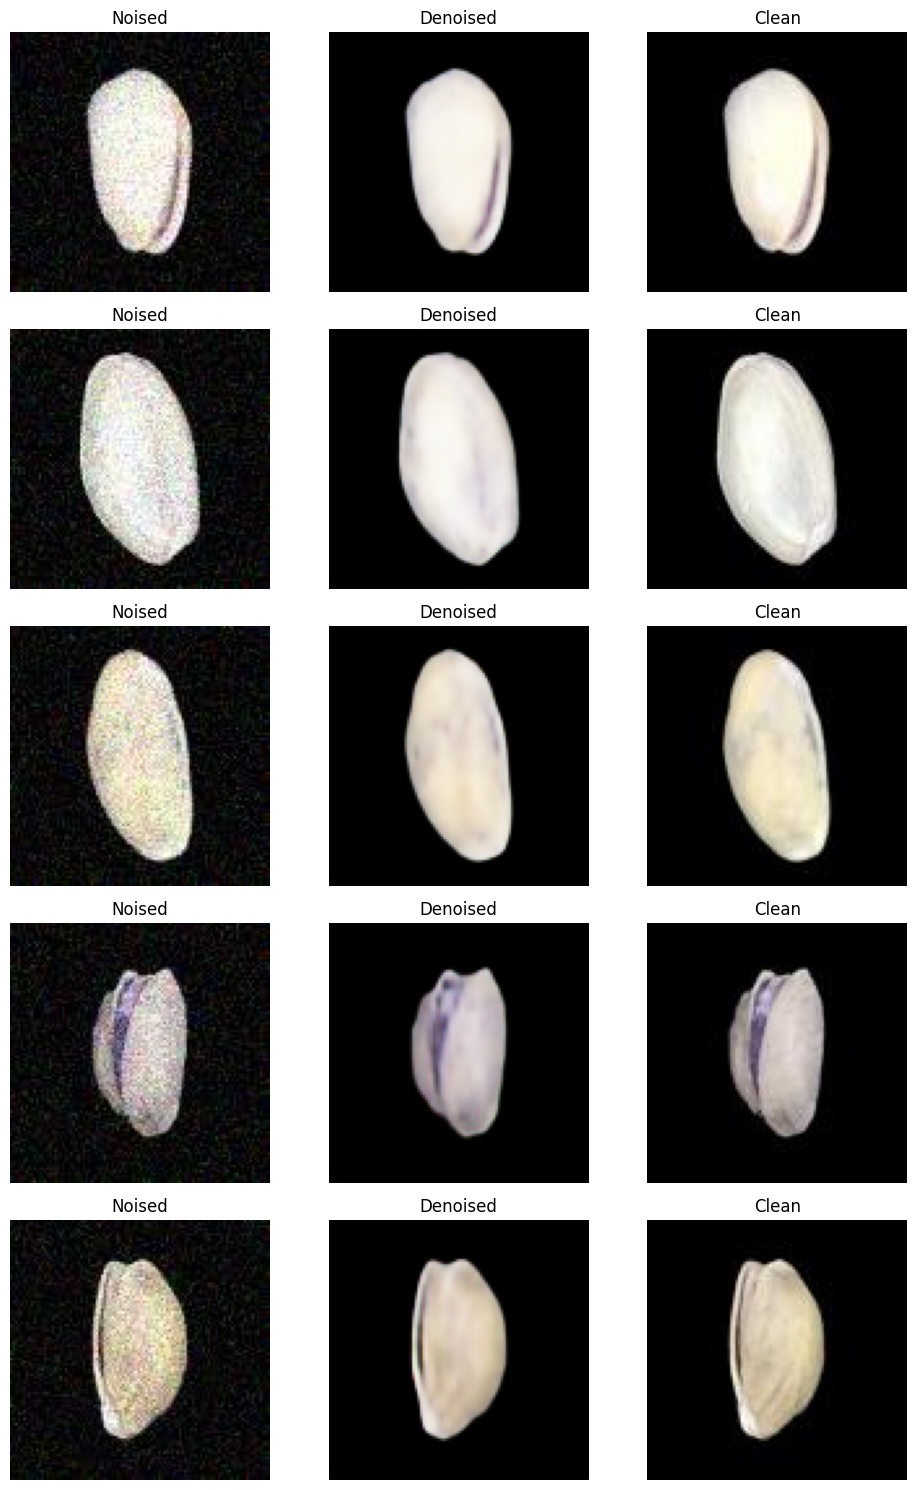

In [ ]:
Y_pred_best = model.predict(X_test)

n = 5

plt.figure(figsize=(10, n * 3))
for i in range(n):
    plt.subplot(n, 3, 3*i + 1)
    plt.imshow(X_test[i])
    plt.title("Noised")
    plt.axis('off')

    plt.subplot(n, 3, 3*i + 2)
    plt.imshow(Y_pred_best[i])
    plt.title("Denoised")
    plt.axis('off')

    plt.subplot(n, 3, 3*i + 3)
    plt.imshow(Y_test[i])
    plt.title("Clean")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Kesimpulan

1. SSIM (Structural Similarity Index)
Nilai: 0.9428
Penjelasan:
SSIM mengukur kemiripan struktur dan visual antara gambar hasil model dengan gambar asli (ground truth), dengan rentang nilai 0 hingga 1.
Nilai di atas 0.5 menandakan gambar hasil sudah cukup mirip secara struktur, dan nilai 0.94 menandakan model sangat baik dalam mempertahankan detail serta struktur gambar asli setelah proses denoising.
Dengan SSIM 0.9428, model mampu menghasilkan gambar yang tidak hanya bebas noise, tetapi juga tetap menjaga bentuk, tekstur, dan fitur penting dari objek gambar.
2. PSNR (Peak Signal to Noise Ratio)
Nilai: 33.30 dB
Penjelasan:
PSNR adalah metrik yang membandingkan perbedaan sinyal asli dan hasil prediksi dalam satuan decibel (dB).
Nilai PSNR di atas 30 dB umumnya dianggap sangat baik untuk citra natural, karena noise residual sangat rendah dan gambar hasil hampir tidak bisa dibedakan dari aslinya secara visual.
Dengan PSNR 33.30 dB, kualitas gambar hasil model sangat mendekati gambar ground truth, noise sudah sangat minimal, dan detail gambar tetap terjaga dengan baik.
3. MSE (Mean Squared Error)
Nilai: 0.000491
Penjelasan:
MSE mengukur rata-rata selisih kuadrat tiap piksel antara gambar hasil dan ground truth.
Nilai MSE yang semakin kecil berarti error model terhadap target semakin rendah.
Nilai MSE yang sangat rendah menunjukkan bahwa mayoritas piksel pada gambar hasil prediksi sudah sangat dekat nilainya dengan piksel pada gambar asli.
4. MAE (Mean Absolute Error)
Nilai: 0.009206
Penjelasan:
MAE mengukur rata-rata selisih absolut antar piksel.
Nilai MAE yang rendah mempertegas bahwa error rata-rata model dalam menebak tiap piksel sangat kecil.
Nilai MAE < 0.01 pada rentang piksel [0, 1] berarti prediksi model sudah sangat akurat di setiap piksel.
Kesimpulan Akhir

Berdasarkan semua metrik evaluasi, model autoencoder yang telah dimodifikasi dan dituning tidak hanya mampu menghilangkan noise secara efektif dari gambar, tetapi juga mampu menjaga detail, struktur, dan kualitas visual gambar asli. Nilai SSIM yang sangat tinggi, PSNR di atas standar kualitas baik, serta error numerik yang sangat kecil, membuktikan bahwa model sudah sangat optimal untuk tugas image denoising pada dataset ini.

# Jokes
Autoencoder pas PDKT bilang ke crush-nya?"
“Aku sih gak ngarep hasilku perfect, yang penting kita mirip!” :)